<a href="https://colab.research.google.com/github/dev02chandan/Neural-Jewels/blob/main/Ring_Superimposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Filtered Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [278]:
image_dir = '/content/drive/MyDrive/Diamond_Ring_Project/Data/new_data'
image_csv = '/content/drive/MyDrive/Diamond_Ring_Project/Data/new_data.csv'
ring_path = '/content/drive/MyDrive/Diamond_Ring_Project/Data/diamondirng.jpg'
hand_image_path_og = '/content/drive/MyDrive/Diamond_Ring_Project/Data/new_data/Hand_0000002.jpg'

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import matplotlib.pyplot as plt

In [ ]:
ring = cv2.imread(ring_path)

In [ ]:
ring[0][0]

array([238, 238, 238], dtype=uint8)

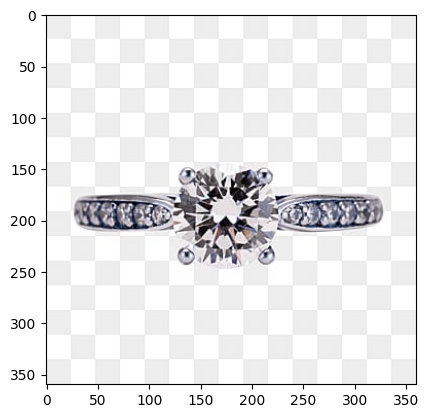

In [ ]:
plt.imshow(ring)

In [ ]:
height, width = ring.shape[:2]

In [ ]:
(height, width)

(360, 360)

## Identify keypoints using Mediapipe

In [ ]:
!pip install mediapipe

In [ ]:
import mediapipe as mp
import cv2

In [ ]:
# Initialize MediaPipe Hands model.
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=True,
                       max_num_hands=1,
                       min_detection_confidence=0.5)

In [ ]:
hand_image = cv2.imread(hand_image_path)
hand_image_rgb = cv2.cvtColor(hand_image, cv2.COLOR_BGR2RGB)

In [ ]:
# Process the image to find hand keypoints.
results = hands.process(hand_image_rgb)

In [ ]:
# Draw the hand keypoints on the image.
if results.multi_hand_landmarks:
    for hand_landmarks in results.multi_hand_landmarks:
        mp_drawing.draw_landmarks(hand_image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

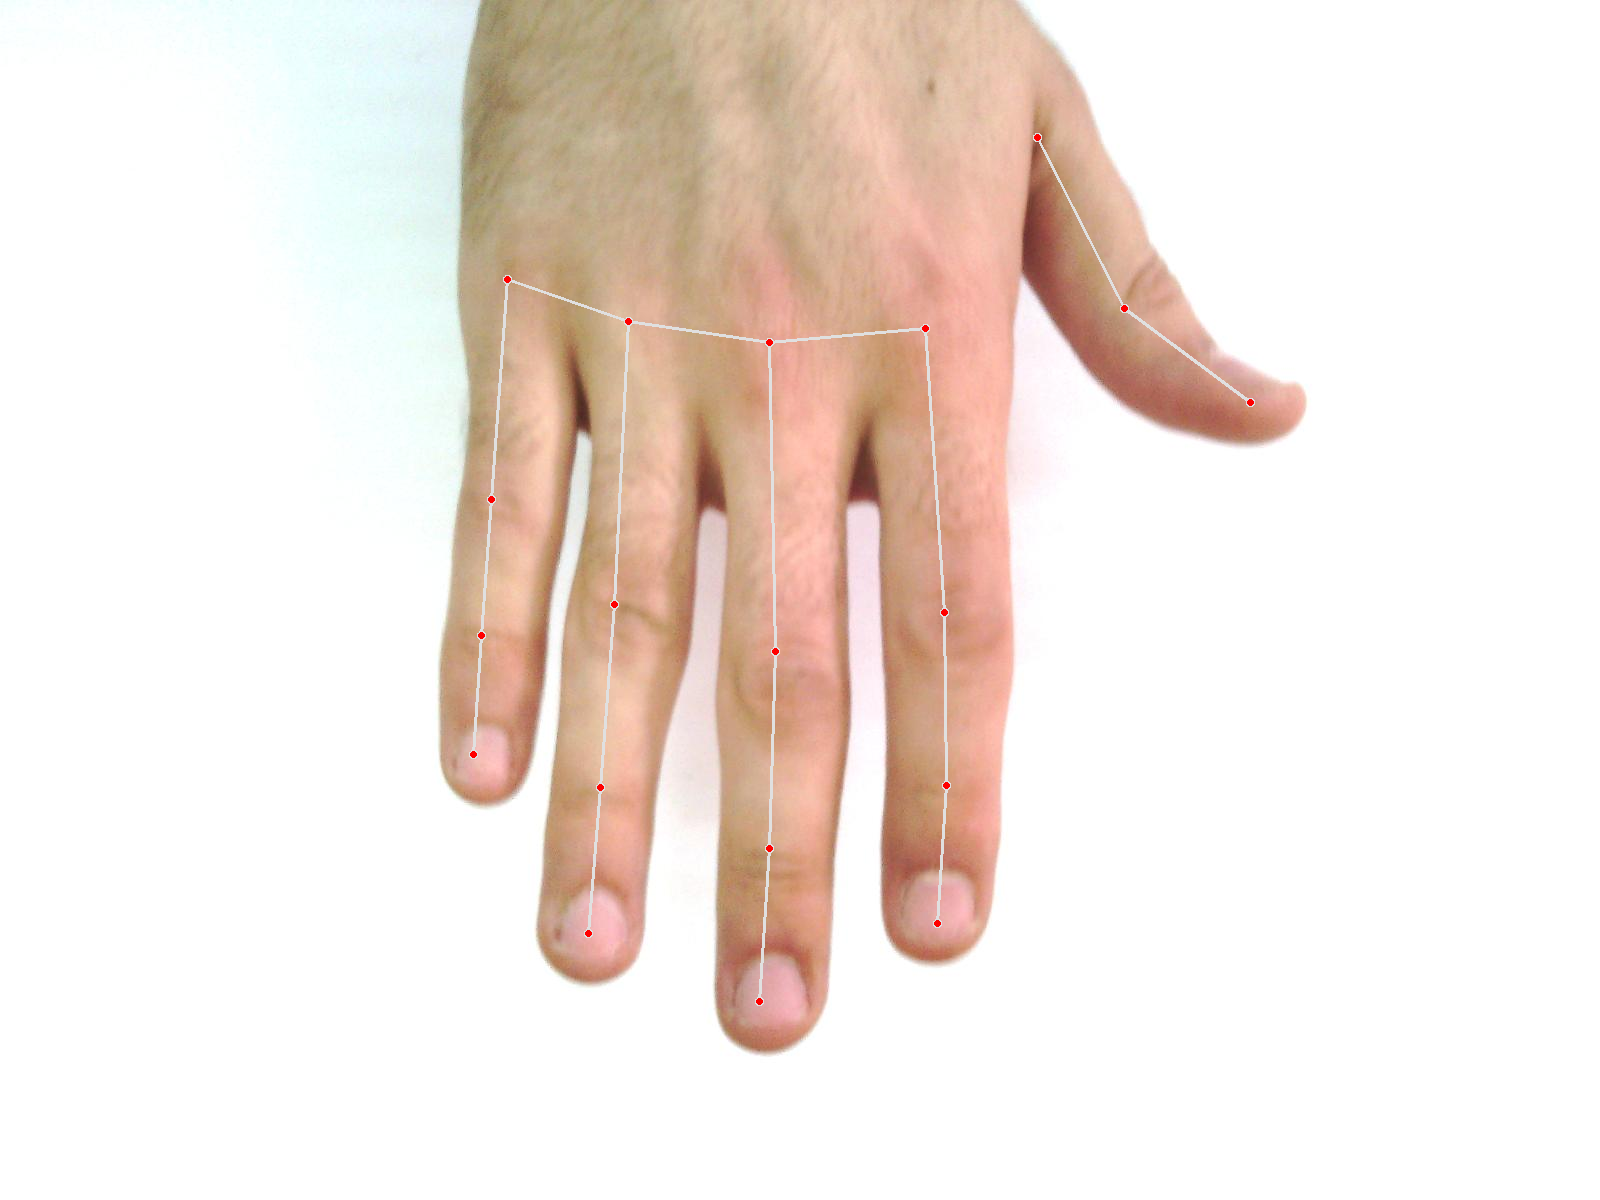

In [ ]:
cv2_imshow(hand_image)

In [ ]:
cv2.imwrite('hand_1_with_keypoints.jpg', hand_image)

True

In [ ]:
if results.multi_hand_landmarks:
    for hand_landmarks in results.multi_hand_landmarks:
        # Get key point coordinates for ring placement.
        ring_finger_base = hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_MCP]
        ring_point = hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_PIP]
        ring_finger_tip = hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_TIP]

        # Convert from relative coordinates to image pixels.
        image_width, image_height = hand_image.shape[1], hand_image.shape[0]
        ring_finger_base_x = int(ring_finger_base.x * image_width)
        ring_finger_base_y = int(ring_finger_base.y * image_height)
        ring_finger_tip_x = int(ring_finger_tip.x * image_width)
        ring_finger_tip_y = int(ring_finger_tip.y * image_height)
        ring_point_x = int(ring_point.x * image_width)
        ring_point_y = int(ring_point.y * image_height)

## Ring sizing

In [ ]:
from PIL import Image, ImageChops

In [ ]:
ring_size = (140, 140)

In [ ]:
# Since the ring is circular, we need to place the ring image such that the ring's center is at the base of the ring finger
# We assume that the base of the ring finger is also the center point of the ring
ring_center_x = ring_point_x - ring_size[0] // 2
ring_center_y = ring_point_y - ring_size[1] // 2

In [ ]:
ring_center_x, ring_center_y

(544, 534)

In [ ]:
ring_image = Image.open(ring_path).resize(ring_size)

In [ ]:
# This function trims the white edges based on the transparency of the image
def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

In [ ]:
ring_image = trim(ring_image)

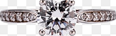

In [ ]:
display(ring_image)

## Poisson Blending

In [ ]:
# Load the hand image
hand_image_path = '/content/hand_1_with_keypoints.jpg'
hand_image = Image.open(hand_image_path)

In [ ]:
import numpy as np

In [ ]:
# Assuming you have the coordinates for the ring finger's base and tip
# and have calculated the distance between them
finger_base_x, finger_base_y = ring_finger_base_x, ring_finger_base_y
finger_tip_x, finger_tip_y = ring_finger_tip_x, ring_finger_tip_y

# Calculate the distance between the base and the tip of the finger
finger_length = ((finger_tip_x - finger_base_x) ** 2 + (finger_tip_y - finger_base_y) ** 2) ** 0.5

ring_diameter = finger_length / 5

# Scale the ring image based on the diameter
ring_image = ring_image.resize((int(ring_diameter), int(ring_diameter)))

In [ ]:
# Convert PIL images to numpy arrays for OpenCV
hand_image_np = np.array(hand_image)
ring_image_np = np.array(ring_image)

# The center for seamlessClone function needs to be a tuple
center = (ring_point_x, ring_point_y)


# Create a mask for the ring image
ring_mask = 255 * np.ones(ring_image_np.shape, ring_image_np.dtype)

# Perform Poisson blending
blended = cv2.seamlessClone(ring_image_np, hand_image_np, ring_mask, center, cv2.NORMAL_CLONE)

# Convert the result back to a PIL image and show or save it
blended_pil = Image.fromarray(blended)
blended_pil.show()

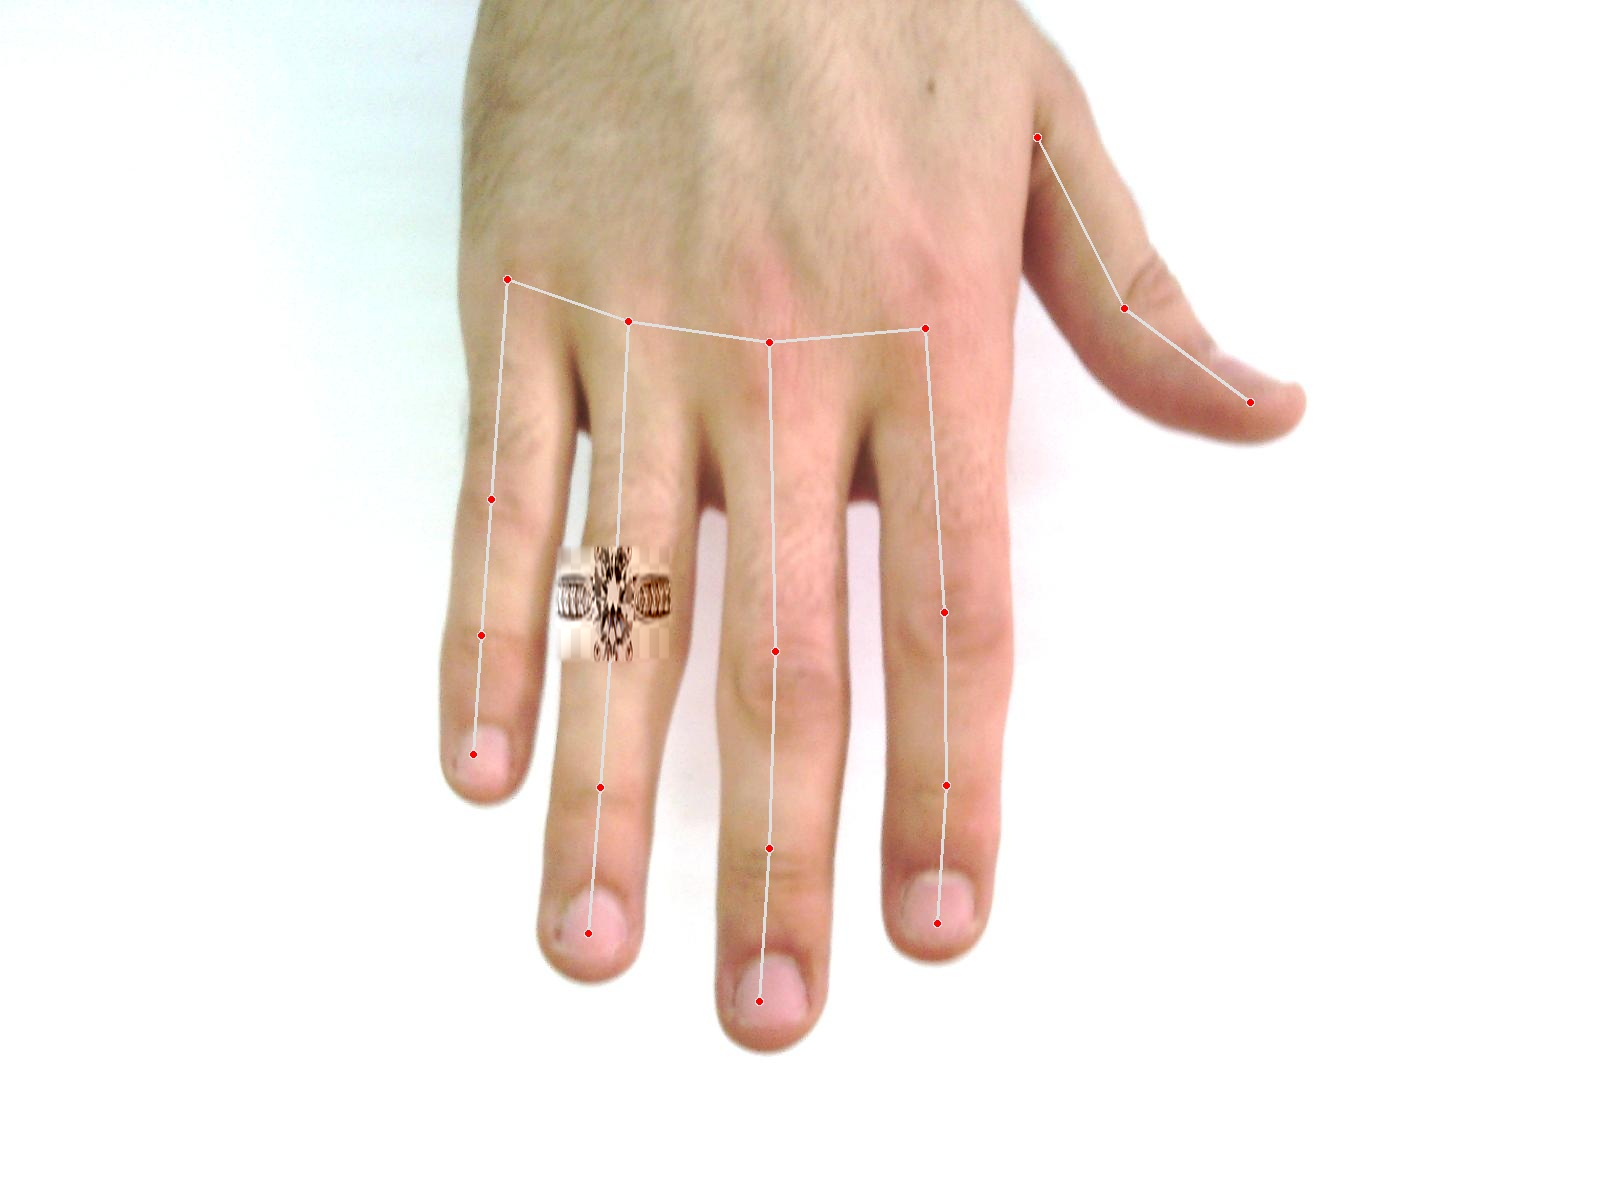

In [ ]:
display(blended_pil)

## Width adjusted Pasting

In [ ]:
# Load the hand image
hand_image_path = '/content/hand_1_with_keypoints.jpg'
hand_image = Image.open(hand_image_path)
image_width, image_height = hand_image.size

In [ ]:
# Get the coordinates for the PIP of the ring finger
ring_point = hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_PIP]
ring_point_x = int(ring_point.x * image_width)
ring_point_y = int(ring_point.y * image_height)

In [ ]:
finger_width = 150

In [ ]:
ring_image_path = ring_path
ring_image = Image.open(ring_image_path)

In [ ]:
ring_aspect_ratio = ring_image.width / ring_image.height
new_ring_width = finger_width
new_ring_height = int(new_ring_width / ring_aspect_ratio)

In [ ]:
ring_image = ring_image.resize((new_ring_width, new_ring_height))

In [ ]:
top_left_x = ring_point_x - new_ring_width // 2
top_left_y = ring_point_y - new_ring_height // 2

In [ ]:
# Create a composite image to handle transparency
composite_image = Image.new("RGBA", hand_image.size)
composite_image.paste(hand_image, (0, 0))
composite_image.paste(ring_image, (top_left_x, top_left_y), None)

In [ ]:
final_image = composite_image.convert("RGB")
final_image.show()

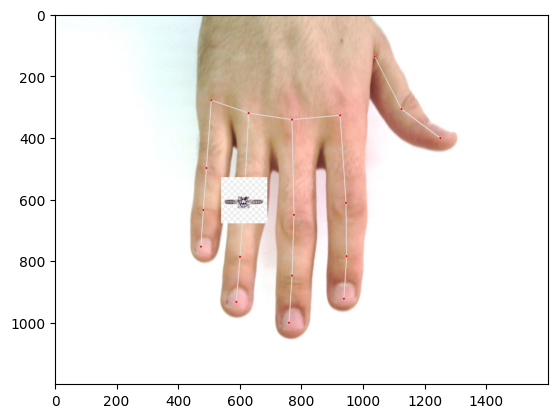

In [ ]:
plt.imshow(final_image)

## Edge Detection for exact Width Finding

In [ ]:
import cv2
import numpy as np

# Load the ring image from the specified path
ring_image = cv2.imread(ring_path, cv2.IMREAD_UNCHANGED)

# Convert the image to grayscale and then binary image for finding contours
gray = cv2.cvtColor(ring_image, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(gray, 225, 255, cv2.THRESH_BINARY_INV)  # Assuming a light background

# Find the largest contour which will be the ring
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)

# Create a mask for the largest contour
mask = np.zeros_like(binary)
cv2.drawContours(mask, [largest_contour], -1, color=255, thickness=cv2.FILLED)

# Use the mask to remove the background
ring_image_background_removed = cv2.bitwise_and(ring_image, ring_image, mask=mask)

# Save or proceed with the ring image with background removed
cv2.imwrite('ring_without_background.png', ring_image_background_removed)

True

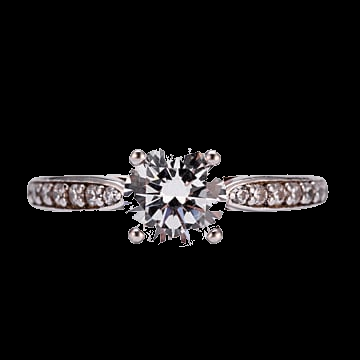

In [ ]:
cv2_imshow(ring_image_background_removed)

In [217]:
hand_image = cv2.imread('/content/drive/MyDrive/Diamond_Ring_Project/Data/new_data/Hand_0000002.jpg', 0)

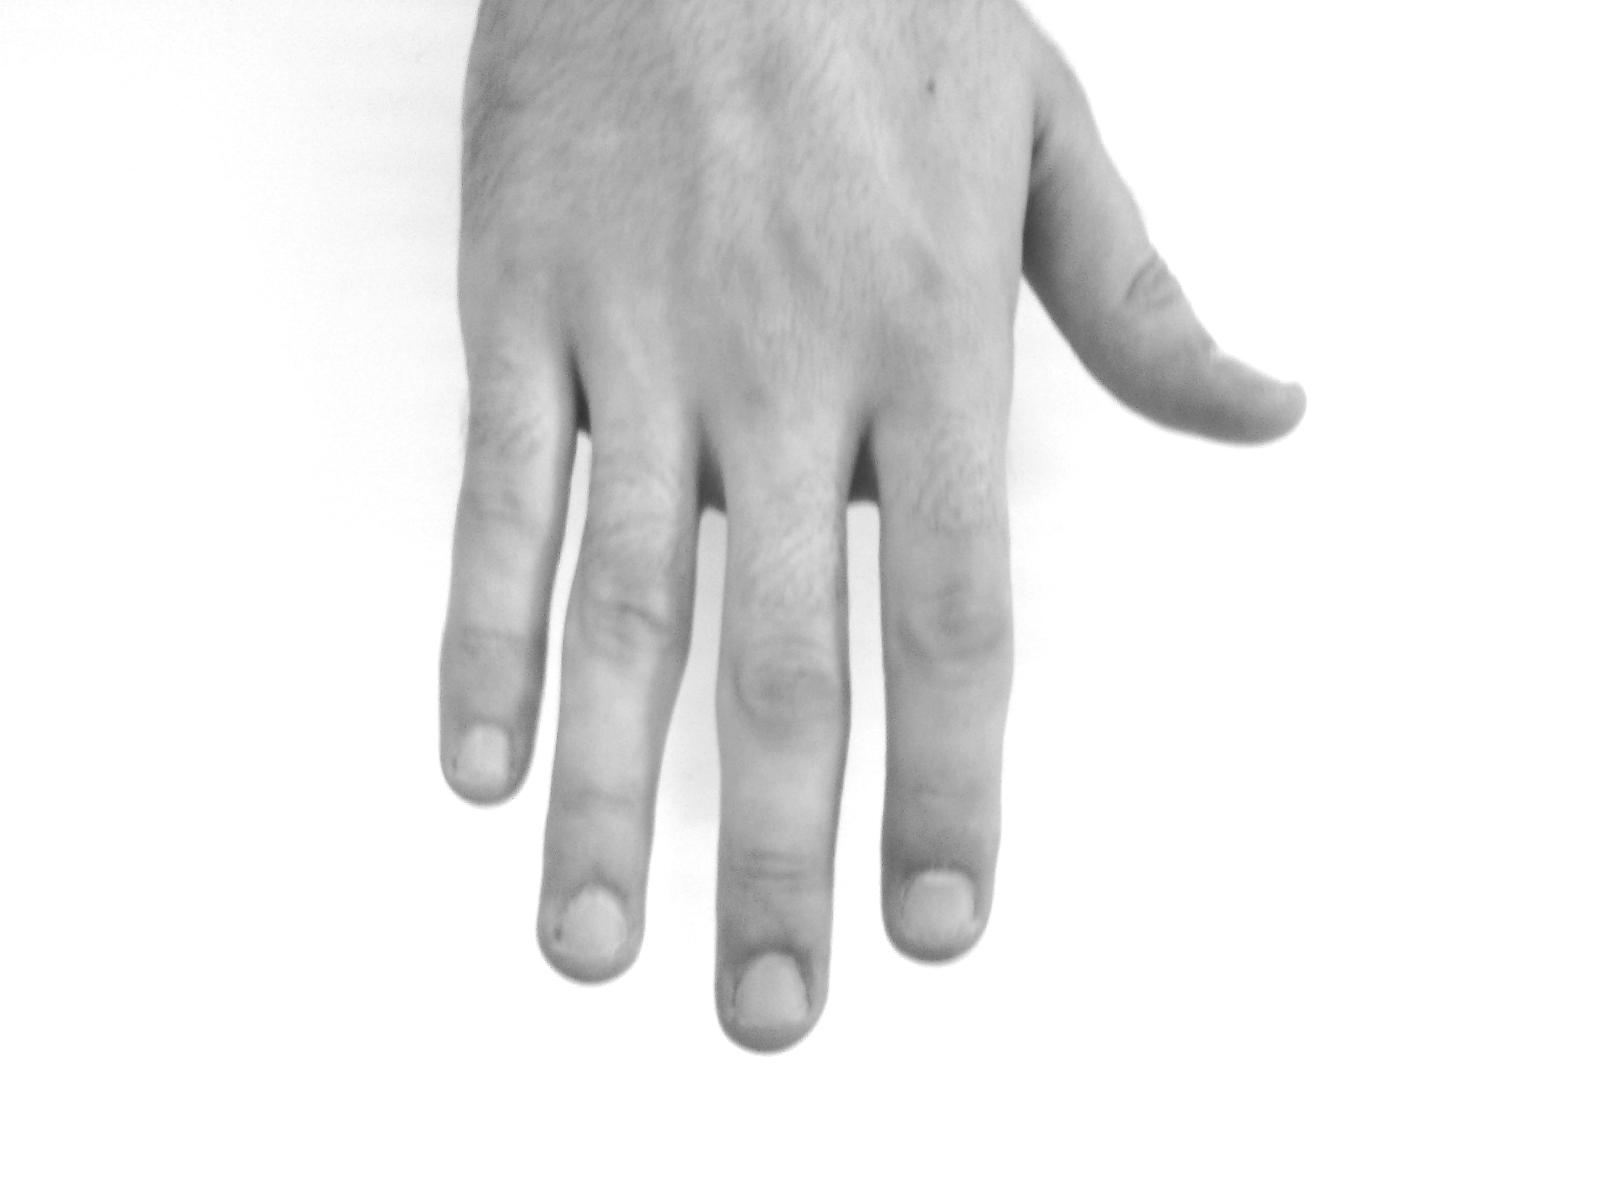

In [218]:
cv2_imshow(hand_image)

In [219]:
blurred_hand_image = cv2.GaussianBlur(hand_image, (5, 5), 0)

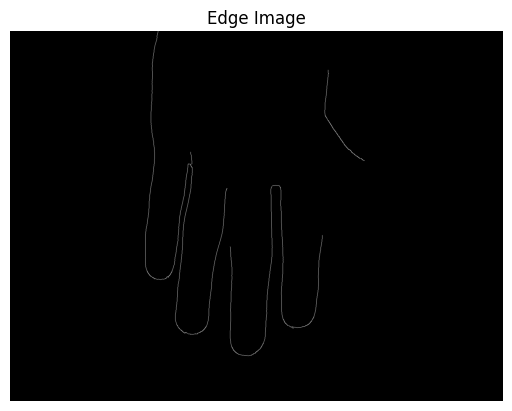

In [220]:
high_threshold_val = 85  # This is just a starting value, you may need to adjust this
edges = cv2.Canny(blurred_hand_image, high_threshold_val, high_threshold_val * 2)

# Display the edges detected in the image
plt.imshow(edges, cmap='gray')
plt.title('Edge Image')
plt.axis('off')  # Hide the x and y axes
plt.show()

In [221]:
ring_finger_pip = hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_PIP]
ring_finger_mp = hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_MCP]

pip_point_x = int(ring_finger_pip.x * image_width)
pip_point_y = int(ring_finger_pip.y * image_height)
mp_point_x = int(ring_finger_mp.x * image_width)
mp_point_y = int(ring_finger_mp.y * image_height)

In [232]:
search_range = 100  # Look 50 pixels to the left and right

In [233]:
edge_values = edges[ pip_point_y , pip_point_x - search_range : pip_point_x + search_range ]

In [234]:
edge_values

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 25

In [242]:
midpoint_index = len(edge_values) // 2

In [249]:
left_index = np.where(edge_values[:midpoint_index] == 255)

In [248]:
left_index

(array([36, 53]),)

In [252]:
# First from the midpoint to the left
left_index = np.where(edge_values[:midpoint_index] == 255)[0][-1]

In [253]:
left_index

53

In [260]:
# First from the midpoint to the right
right_index = np.where(edge_values[midpoint_index:] == 255)[0][0]

In [261]:
right_index

80

In [270]:
left_idx = pip_point_x - (midpoint_index - left_index)
right_idx = pip_point_x + right_index

In [271]:
left_idx

567

In [272]:
right_idx

694

In [273]:
from PIL import ImageDraw

In [274]:
image = Image.open('/content/hand_1_with_keypoints.jpg')
draw = ImageDraw.Draw(image)
draw.line([(right_idx,pip_point_y)  ,(left_idx, pip_point_y)], fill="red", width=2)

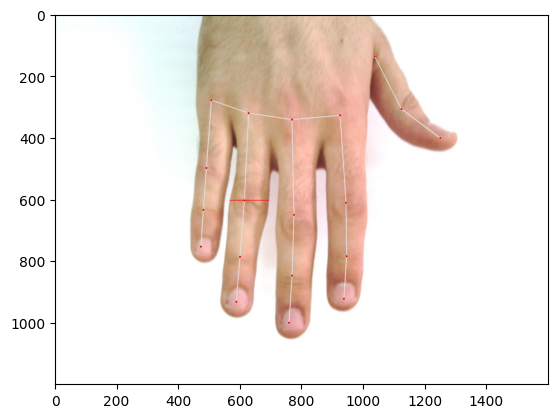

In [275]:
plt.imshow(image)

## Imposition of Ring on Hand

In [281]:
hand = Image.open(hand_image_path_og)
hand_image_pil = Image.fromarray(hand_image)

In [284]:
ring_image = cv2.imread('/content/ring_without_background.png', cv2.IMREAD_UNCHANGED)

In [285]:
_, mask = cv2.threshold(cv2.cvtColor(ring_image, cv2.COLOR_BGR2GRAY), 1, 255, cv2.THRESH_BINARY)
ring_image_rgba = cv2.cvtColor(ring_image, cv2.COLOR_BGR2BGRA)
ring_image_rgba[:, :, 3] = mask

In [286]:
ring_image_pil = Image.fromarray(ring_image_rgba)

# Calculate the width of the finger
finger_width_px = right_idx - left_idx

In [298]:
# Resize the ring image to match the finger's width
ring_aspect_ratio = ring_image_pil.width / ring_image_pil.height
new_ring_width = finger_width_px + 20
new_ring_height = int(new_ring_width / ring_aspect_ratio)
ring_image_resized = ring_image_pil.resize((new_ring_width, new_ring_height), Image.ANTIALIAS)


<ipython-input-298-1afb49700f80>:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  ring_image_resized = ring_image_pil.resize((new_ring_width, new_ring_height), Image.ANTIALIAS)


In [299]:
# Calculate the position to paste the ring image on the hand image, so it's centered on the finger
top_left_x = left_idx
top_left_y = pip_point_y - new_ring_height // 2

In [300]:
composite_image = Image.new("RGBA", hand_image_pil.size)
composite_image.paste(hand_image_pil, (0, 0))
composite_image.paste(ring_image_resized, (top_left_x, top_left_y), ring_image_resized)

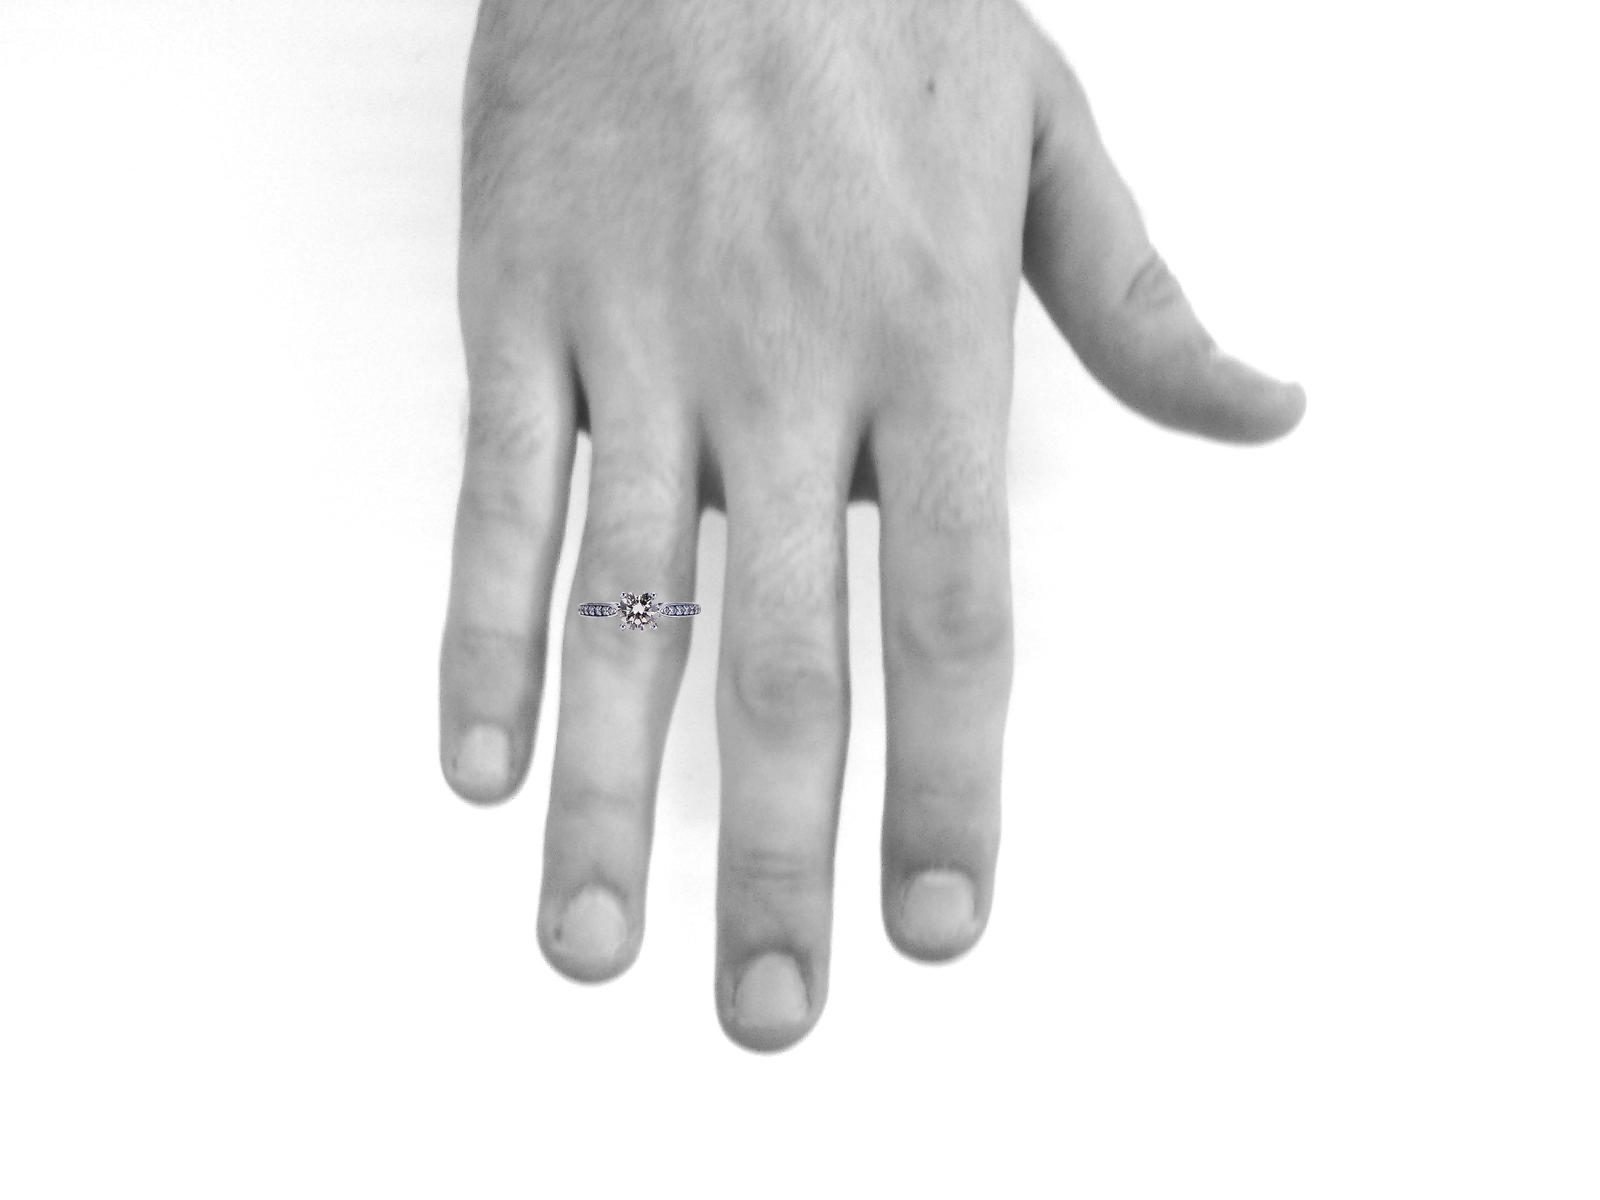

In [301]:
final_image = composite_image.convert("RGB")
display(final_image)

In [301]:
# Next - calculate orientation and fit the ring